<h1><center>Анализ эффекта внедрения нового алгоритма подбора команд в Guns of Boom</center></h1>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
% matplotlib inline

In [2]:
# Импортируем данные

data = pd.read_csv('testProdAnl.csv')

## Часть 1. Посмотрим на данные поподробнее

In [3]:
data.head()

,user_id,battle_id,team,start_time,level,frags,deaths,assists
0,429769,5817db18-c398-6a01-7af8-3dd29d1fd781,1,2016-11-01,40,13,4,6
1,311033,5817db18-c398-6a01-7af8-3dd29d1fd781,1,2016-11-01,34,12,9,7
2,402849,5817db18-c398-6a01-7af8-3dd29d1fd781,1,2016-11-01,38,11,5,6
3,24488,5817db18-c398-6a01-7af8-3dd29d1fd781,1,2016-11-01,34,8,7,12
4,447678,5817db18-c398-6a01-7af8-3dd29d1fd781,2,2016-11-01,29,8,8,3


In [4]:
# Количество записей в датасете

data.shape

(666296, 8)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666296 entries, 0 to 666295
Data columns (total 8 columns):
user_id       666296 non-null int64
battle_id     666296 non-null object
team          666296 non-null int64
start_time    666296 non-null object
level         666296 non-null int64
frags         666296 non-null int64
deaths        666296 non-null int64
assists       666296 non-null int64
dtypes: int64(6), object(2)
memory usage: 40.7+ MB


Все данные, кроме двух, целочисленны. Battle_id сгодится и в таком виде, а дату сессии сразу переведем в формат даты.

In [6]:
data['start_time'] = pd.to_datetime(data['start_time'])

In [7]:
# Взглянем на распределение целочисленных признаков и подкрепим их гистограммами

data.describe()

,user_id,team,level,frags,deaths,assists
count,666296.000000,666296.0,666296.000000,666296.000000,666296.000000,666296.000000
mean,594856.674550,1.5,18.503766,7.327566,7.428121,5.389903
std,251519.975117,0.5,10.961394,3.933230,2.831631,2.862892
min,3884.000000,1.0,1.000000,0.000000,0.000000,0.000000
25%,378338.000000,1.0,8.000000,5.000000,6.000000,3.000000
50%,681943.000000,1.5,18.000000,7.000000,8.000000,5.000000
75%,815369.000000,2.0,29.000000,10.000000,9.000000,7.000000
max,885439.000000,2.0,45.000000,43.000000,23.000000,23.000000


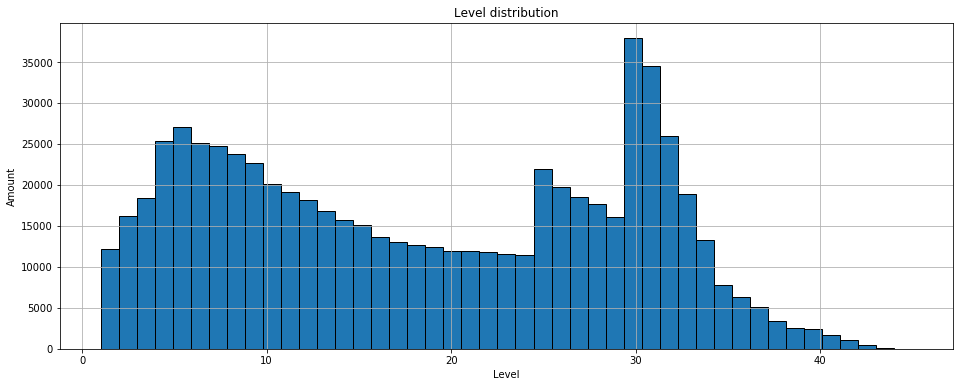

In [8]:
fig = plt.figure(figsize = (16, 6))
data.level.hist(bins = 45, edgecolor = 'black')
plt.xlabel('Level')
plt.ylabel('Amount')
plt.title('Level distribution')
plt.show()

Уровень игроков, принимавших участие в тестировании, находится между 1 и 45. Явно различимы два максимума плотности распределения игроков по уровням: новички (5-15 уровень) и игроки с примерно 25 до 32 уровня. Можно предположить, что второй пик связан с открытием дополнительного интереса к игре или введением новой механики на 25-м уровне.

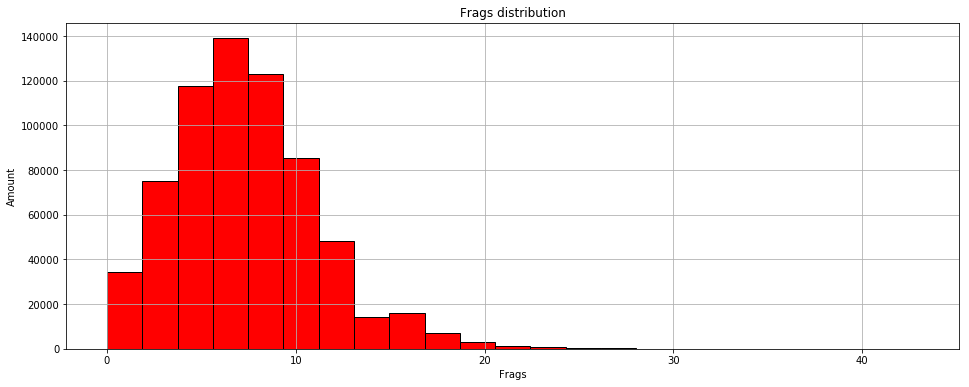

In [9]:
fig = plt.figure(figsize = (16, 6))
data.frags.hist(edgecolor = 'black', bins = 23, color = 'red')
plt.xlabel('Frags')
plt.ylabel('Amount')
plt.title('Frags distribution')
plt.show()

Распределение количества фрагов игроков в сессии похоже на нормальное и распределено между 0 и 43 фрагами за бой. 

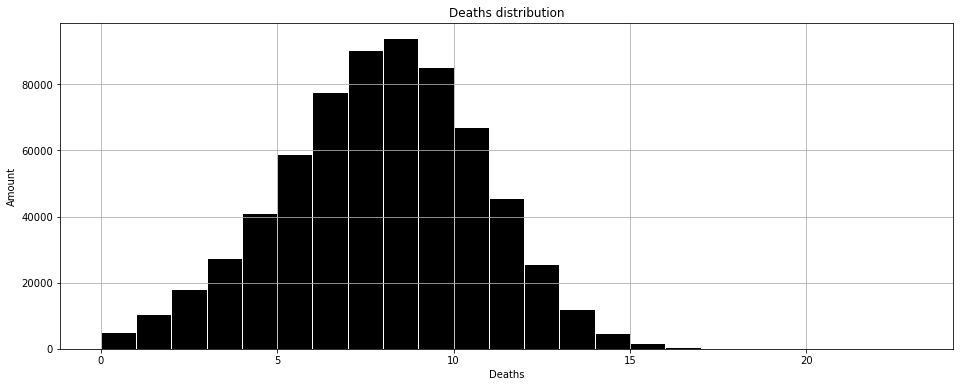

In [10]:
fig = plt.figure(figsize = (16, 6))
data.deaths.hist(edgecolor = 'white', bins = 23, color = 'black')
plt.xlabel('Deaths')
plt.ylabel('Amount')
plt.title('Deaths distribution')
plt.show()

Распределение смертей игрока в матче еще больше похоже на нормальное, чем распределение фрагов, со средним на примерно том же уровне, но с меньшим разбросом.

In [11]:
data['start_time'].value_counts()

2016-11-06    55240
2016-11-05    51362
2016-11-13    39472
2016-11-12    38781
2016-11-07    38576
2016-11-04    38510
2016-11-02    37428
2016-11-01    37348
2016-11-08    35750
2016-11-09    32546
2016-11-11    31953
2016-11-10    31944
2016-11-03    30864
2016-11-14    29575
2016-11-19    29280
2016-11-15    28721
2016-11-16    28546
2016-11-17    27296
2016-11-18    23104
Name: start_time, dtype: int64

Исследование проводилось 19 дней: с 1 по 19 ноября 2016 года.

## Часть 2. Создание новых признаков и определение даты введения нового алгоритма

Создадим новый датасет с новыми признаками, более подходящими для анализа.

In [12]:
# Разделим исходный датасет на два, каждый из которых соответствует одной команде

team1_data = data[data['team'] == 1]
team2_data = data[data['team'] == 2]

In [13]:
# Сгенерируем новые признаки:
# - Средние уровни по битве первой и второй команд
# - Среднее количество фрагов по битве для первой и второй команд
# - Среднее количество смертей по битве для первой и второй команд
# - Среднее количество ассистов по битве для первой и второй команд
# - Дата боя
# - Уникалье id битвы

team1_level = team1_data.groupby(['battle_id'])['level'].mean()
team2_level = team2_data.groupby(['battle_id'])['level'].mean()
team1_frags = team1_data.groupby(['battle_id'])['frags'].mean()
team2_frags = team2_data.groupby(['battle_id'])['frags'].mean()
team1_deaths = team1_data.groupby(['battle_id'])['deaths'].mean()
team2_deaths = team2_data.groupby(['battle_id'])['deaths'].mean()
team1_assists = team1_data.groupby(['battle_id'])['assists'].mean()
team2_assists = team2_data.groupby(['battle_id'])['assists'].mean()
battle_time = data.groupby(['battle_id'])['start_time'].last()
battle_ids = data['battle_id'].unique()

In [14]:
# Соберем признаки в новый датафрейм

teams = [('start_time', battle_time), ('battle_id', battle_ids),
         ('t1_frags', team1_frags), ('t2_frags', team2_frags),
         ('t1_level', team1_level), ('t2_level', team2_level),
         ('t1_deaths', team1_deaths), ('t2_deaths', team2_deaths), 
         ('t1_assists', team1_assists), ('t2_assists', team2_assists)]

df = pd.DataFrame.from_items(teams)
df = df.reset_index(drop = True)

In [15]:
df.head(10)

,start_time,battle_id,t1_frags,t2_frags,t1_level,t2_level,t1_deaths,t2_deaths,t1_assists,t2_assists
0,2016-11-01,5817db18-c398-6a01-7af8-3dd29d1fd781,11.00,6.25,36.50,30.00,6.25,11.00,7.75,6.25
1,2016-11-01,5817db98-c428-6a01-98b0-5c6aa6eef709,5.00,7.50,30.00,27.00,7.75,5.25,3.50,5.25
2,2016-11-01,5817dba5-c435-6a01-dc71-9e132e169a58,6.75,7.00,8.75,9.00,7.25,7.00,4.25,3.75
3,2016-11-01,5817dbe1-c478-6a01-d6a7-015aafb1b932,9.75,7.50,33.25,32.25,8.00,10.25,9.00,6.75
4,2016-11-01,5817dc22-c4b7-6a01-a6fc-ee26d53885dd,8.75,9.50,31.50,32.75,9.50,8.75,7.75,8.75
5,2016-11-01,5817dc30-c4c8-6a01-b87c-0c5a49600dc0,7.25,8.50,22.75,15.25,9.50,8.25,5.50,7.25
6,2016-11-01,5817dc4b-c4e2-6a01-9743-14a9a51fe2f0,8.00,7.75,30.50,28.50,7.75,8.00,5.75,5.25
7,2016-11-01,5817dca8-c545-6a01-d7f6-933604ebdcf2,5.25,6.75,18.25,24.75,6.75,5.00,3.25,5.00
8,2016-11-01,5817dcae-c54b-6a01-cb53-77d7edfbe1c1,11.00,8.50,33.00,31.75,8.50,11.00,8.75,6.00
9,2016-11-01,5817dcf5-c5af-6a01-7dad-3e8e0bcf4539,11.25,11.00,31.50,31.25,11.00,11.25,8.75,10.00


In [16]:
# Добавим признак, соответствующий относительной разности средних уровней двух команд в матче

df['level_diff'] = np.abs((df['t1_level'] - df['t2_level']) / df['t1_level'])

Предполагаю, что новый алгоритм подбора игроков должен в первую очередь повлиять на состав участников каждого боя: должно измениться соотношение уровней играющих. Поэтому в качется первого предположения для определения даты смены алгоритма сделаю следующее: должно измениться соотношение средних уровней команд в бою.

Проверим на графике зависимости относительной разности уровней игроков в двух встречающихся командах от даты.

In [17]:
df.groupby(['start_time'])['level_diff'].mean()

start_time
2016-11-01    0.171511
2016-11-02    0.165378
2016-11-03    0.166080
2016-11-04    0.173540
2016-11-05    0.192328
2016-11-06    0.193416
2016-11-07    0.177667
2016-11-08    0.172292
2016-11-09    0.169404
2016-11-10    0.110188
2016-11-11    0.061918
2016-11-12    0.058614
2016-11-13    0.056307
2016-11-14    0.060564
2016-11-15    0.059636
2016-11-16    0.059769
2016-11-17    0.063049
2016-11-18    0.060899
2016-11-19    0.065779
Name: level_diff, dtype: float64

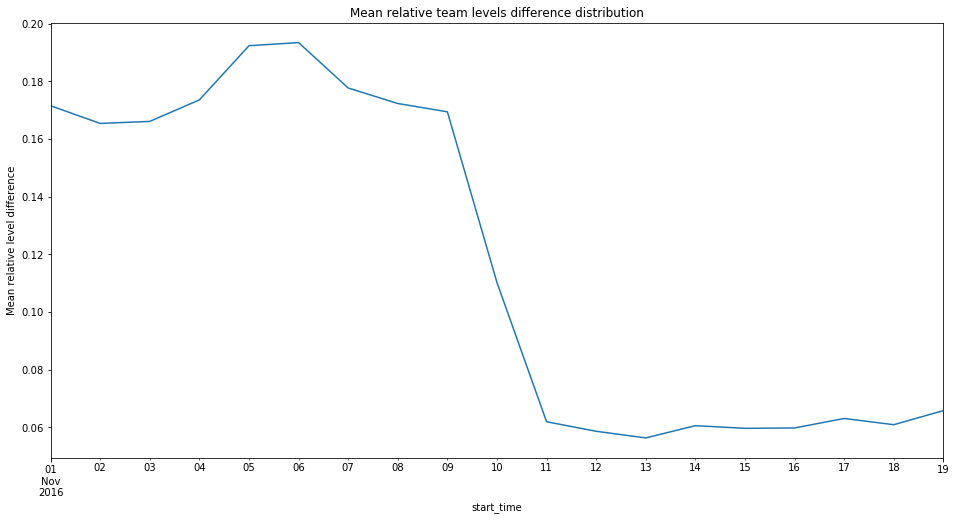

In [18]:
df.groupby(['start_time'])['level_diff'].mean().plot(figsize = (16, 8))
plt.ylabel('Mean relative level difference')
plt.title('Mean relative team levels difference distribution');

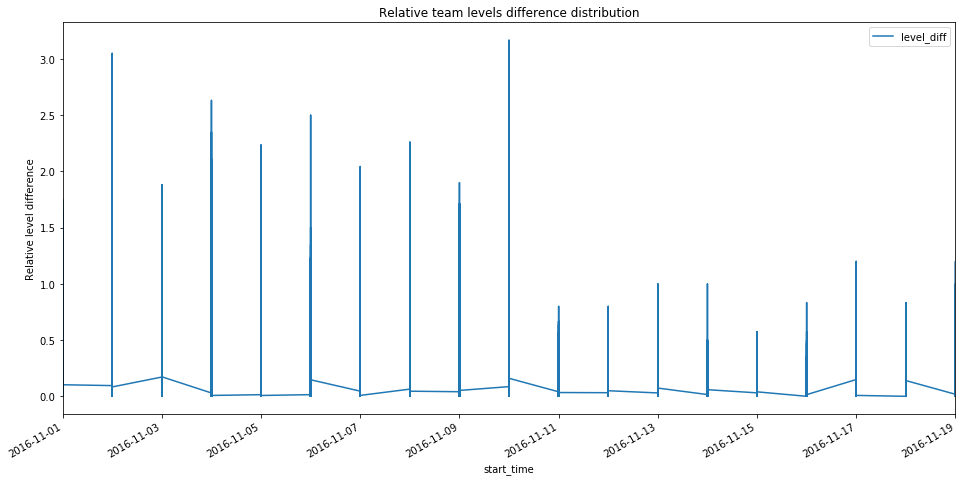

In [19]:
df.plot(y = 'level_diff', x = 'start_time', figsize = (16, 8), 
        title = 'Relative team levels difference distribution')
plt.ylabel('Relative level difference');

Действительно, до 10 ноября уровень команд мог сильно отличаться. Начиная с 11 ноября разброс в уровнях команд стал стабильно и значительно меньше. Отсюда могу положить, что новый алгоритм подбора игроков 11 ноября уже работал. Строго говоря, резкое падение разницы в уровне игроков в бою началось еще 10 ноября. Так можно предположить, что выкачен он был примерно в середине тестового дня 10 ноября.

## Часть 3. Анализ изменений

In [20]:
# Добавим новые признаки, соответствующие относительной разности среднего числа фрагов, смертей и ассистов
# двух команд в матче

df['frags_diff'] = np.abs((df['t1_frags'] - df['t2_frags']) / df['t1_frags'])
df['deaths_diff'] = np.abs((df['t1_deaths'] - df['t2_deaths']) / df['t1_deaths'])
df['assists_diff'] = np.abs((df['t1_assists'] - df['t2_assists']) / df['t1_assists'])

In [21]:
# Разделим данные на до и после изменений. Поскольку 10 ноября мы считаем переходным днем, то для чистоты выводов
# выведем его из наблюдений

df_before = df[df['start_time'] < '2016-11-10']
df_after = df[df['start_time'] > '2016-11-10']
df_after = df_after.reset_index()
df_after = df_after.drop('index', axis = 1)

In [22]:
print('Количество наблюдений до смены алгоритма: %s' % df_before.shape[0])
print('Количество наблюдений после смены алгоритма: %s' % df_after.shape[0])

Количество наблюдений до смены алгоритма: 44703
Количество наблюдений после смены алгоритма: 34591


### Часть 3.1. Анализ изменений средних показателей

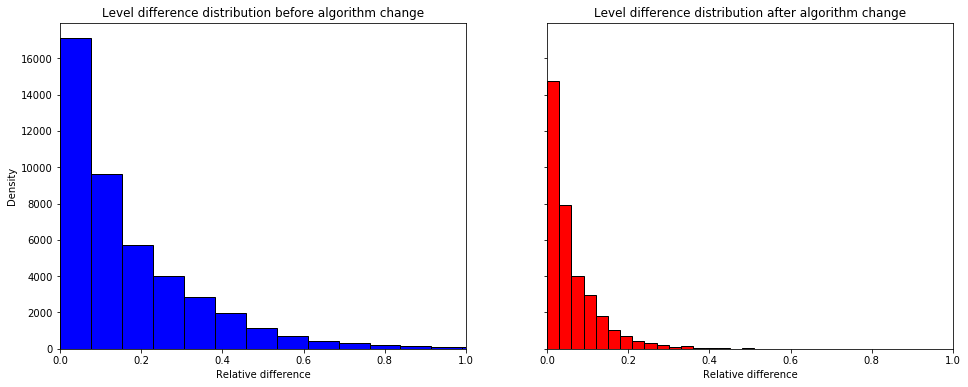

In [23]:
# Посмотрим на изменение средней разницы в уровнях двух команд в одном бою после смены алгоритма

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey = True, figsize = (16, 6))
ax1.hist(df_before['level_diff'], bins = 40, color = 'blue', edgecolor = 'black')
ax1.set_title('Level difference distribution before algorithm change')
ax2.hist(df_after['level_diff'], bins = 40, color = 'red', edgecolor = 'black')
plt.xlim([0, 1])
ax2.set_title('Level difference distribution after algorithm change')
ax1.set_xlabel('Relative difference')
ax2.set_xlabel('Relative difference')
ax1.set_ylabel('Density')
ax1.set_ylabel('Density')
plt.show()

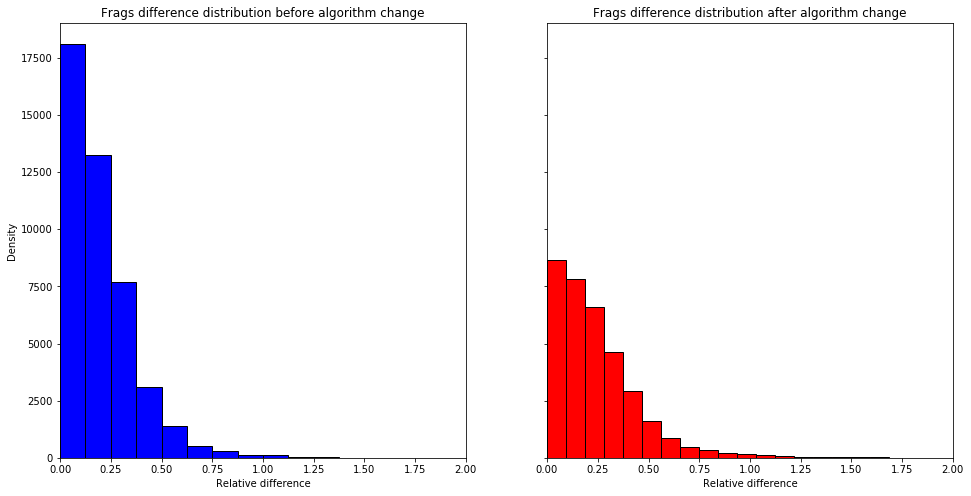

In [24]:
# Средняя разница в счете боя

f, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (16, 8))
ax1.hist(df_before['frags_diff'].dropna(), bins = 40, color = 'blue', edgecolor = 'black')
ax2.hist(df_after['frags_diff'].dropna(), bins = 40, color = 'red', edgecolor = 'black')
plt.xlim([0, 2])
ax1.set_title('Frags difference distribution before algorithm change')
ax2.set_title('Frags difference distribution after algorithm change')
ax1.set_xlabel('Relative difference')
ax2.set_xlabel('Relative difference')
ax1.set_ylabel('Density')
plt.show()

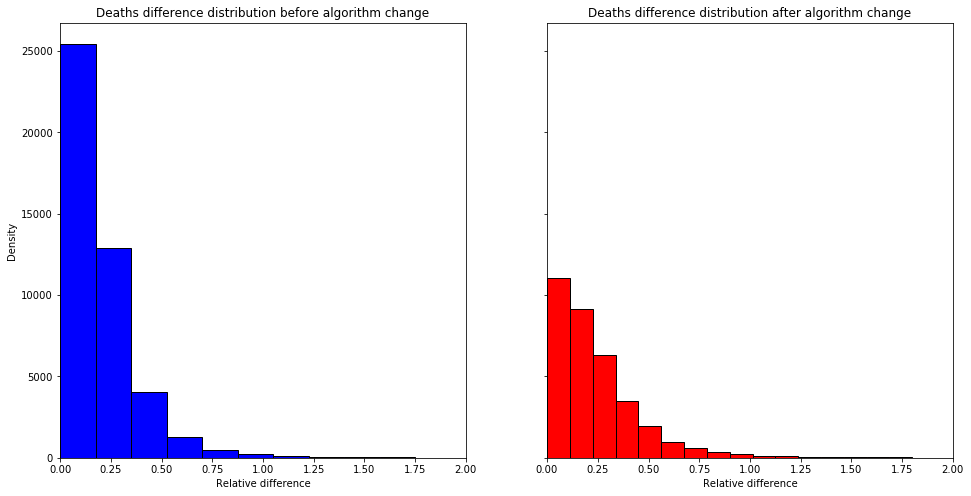

In [25]:
# Средняя разница в смертях двух команд в матче

f, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (16, 8))
ax1.hist(df_before['deaths_diff'].dropna(), bins = 40, color = 'blue', edgecolor = 'black')
ax2.hist(df_after['deaths_diff'].dropna(), bins = 40, color = 'red', edgecolor = 'black')
plt.xlim([0, 2])
ax1.set_title('Deaths difference distribution before algorithm change')
ax2.set_title('Deaths difference distribution after algorithm change')
ax1.set_xlabel('Relative difference')
ax2.set_xlabel('Relative difference')
ax1.set_ylabel('Density')
plt.show()

После смены алгоритма подбора игроков разница в среднем уровне игроков двух команд в бою уменьшилась, при этом разница в финальном счете, как и количество смертей увеличилась.

### Часть 3.2. Анализ изменений по группам

Рассмотрим чуть подробнее изменение указанных параметров по группам игроков

In [26]:
data_before = data[data['start_time'] < '2016-11-10']
data_after = data[data['start_time'] > '2016-11-10']
data_after = data_after.reset_index()
data_after = data_after.drop('index', axis = 1)

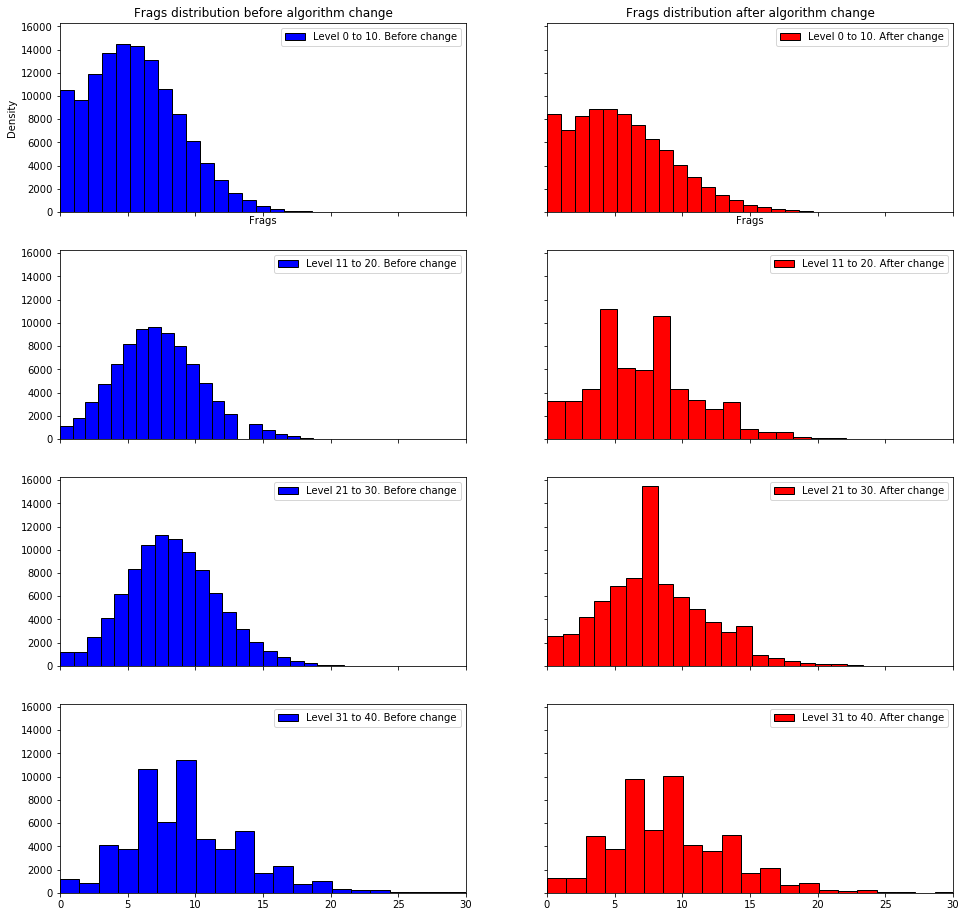

In [27]:
f, axes = plt.subplots(4, 2, sharex = True, sharey = True, figsize = (16, 16))
axes[0, 0].hist(data_before[data_before['level'] <= 10]['frags'].dropna(), 
                bins = 30, color = 'blue', edgecolor = 'black')
axes[0, 1].hist(data_after[data_after['level'] <= 10]['frags'].dropna(), 
                bins = 30, color = 'red', edgecolor = 'black')
axes[1, 0].hist(data_before[(data_before['level'] > 10) & (data_before['level'] <= 20)]['frags'].dropna(), 
                bins = 30, color = 'blue', edgecolor = 'black')
axes[1, 1].hist(data_after[(data_after['level'] > 10) & (data_after['level'] <= 20)]['frags'].dropna(), 
                bins = 30, color = 'red', edgecolor = 'black')
axes[2, 0].hist(data_before[(data_before['level'] > 20) & (data_before['level'] <= 30)]['frags'].dropna(), 
                bins = 30, color = 'blue', edgecolor = 'black')
axes[2, 1].hist(data_after[(data_after['level'] > 20) & (data_after['level'] <= 30)]['frags'].dropna(), 
                bins = 30, color = 'red', edgecolor = 'black')
axes[3, 0].hist(data_before[(data_before['level'] > 30) & (data_before['level'] <= 40)]['frags'].dropna(), 
                bins = 30, color = 'blue', edgecolor = 'black')
axes[3, 1].hist(data_after[(data_after['level'] > 30) & (data_after['level'] <= 40)]['frags'].dropna(), 
                bins = 30, color = 'red', edgecolor = 'black')
axes[0, 0].set_title('Frags distribution before algorithm change')
axes[0, 1].set_title('Frags distribution after algorithm change')
axes[0, 0].legend(['Level 0 to 10. Before change'])
axes[0, 1].legend(['Level 0 to 10. After change'])
axes[1, 0].legend(['Level 11 to 20. Before change'])
axes[1, 1].legend(['Level 11 to 20. After change'])
axes[2, 0].legend(['Level 21 to 30. Before change'])
axes[2, 1].legend(['Level 21 to 30. After change'])
axes[3, 0].legend(['Level 31 to 40. Before change'])
axes[3, 1].legend(['Level 31 to 40. After change'])
axes[0, 0].set_xlabel('Frags')
axes[0, 1].set_xlabel('Frags')
axes[0, 0].set_ylabel('Density')
plt.xlim([0, 30])
plt.show()

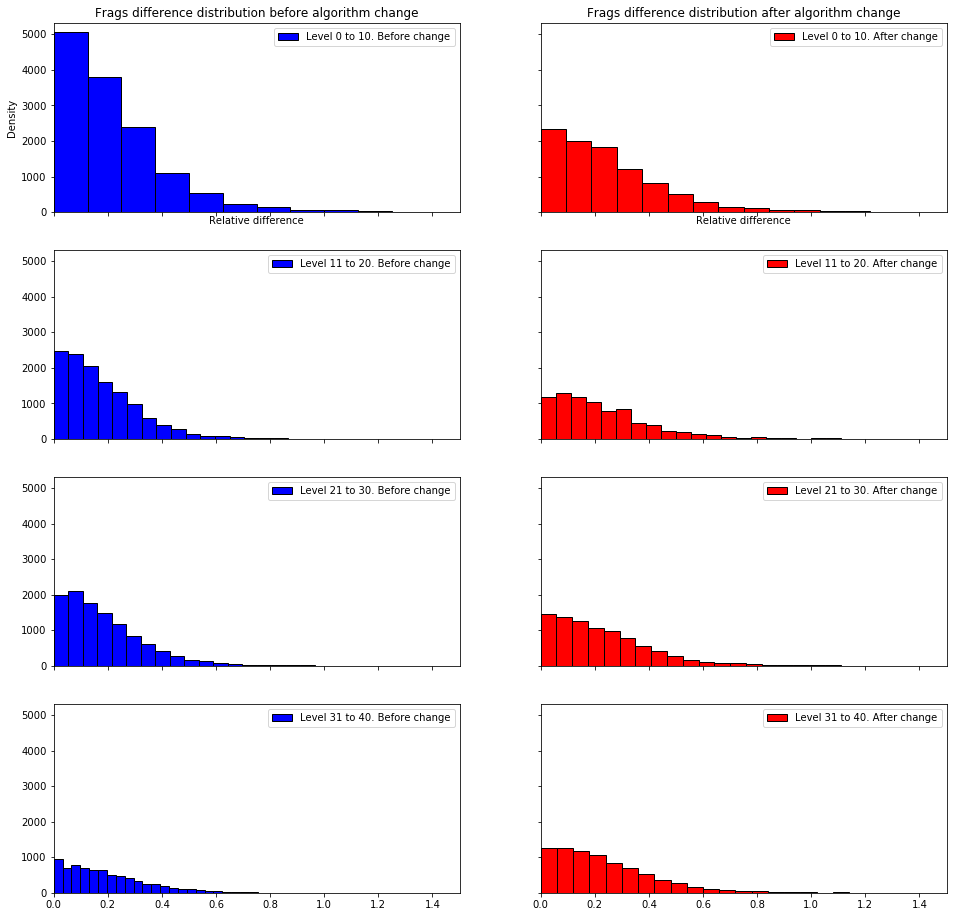

In [28]:
f, axes = plt.subplots(4, 2, sharex = True, sharey = True, figsize = (16, 16))
axes[0, 0].hist(df_before[df_before['t1_level'] <= 10]['frags_diff'].dropna(), 
                bins = 40, color = 'blue', edgecolor = 'black')
axes[0, 1].hist(df_after[df_after['t1_level'] <= 10]['frags_diff'].dropna(), 
                bins = 40, color = 'red', edgecolor = 'black')
axes[1, 0].hist(df_before[(df_before['t1_level'] > 10) & (df_before['t1_level'] <= 20)]['frags_diff'].dropna(), 
         bins = 40, color = 'blue', edgecolor = 'black')
axes[1, 1].hist(df_after[(df_after['t1_level'] > 10) & (df_after['t1_level'] <= 20)]['frags_diff'].dropna(), 
                bins = 40, color = 'red', edgecolor = 'black')
axes[2, 0].hist(df_before[(df_before['t1_level'] > 20) & (df_before['t1_level'] <= 30)]['frags_diff'].dropna(), 
         bins = 40, color = 'blue', edgecolor = 'black')
axes[2, 1].hist(df_after[(df_after['t1_level'] > 20) & (df_after['t1_level'] <= 30)]['frags_diff'].dropna(), 
                bins = 40, color = 'red', edgecolor = 'black')
axes[3, 0].hist(df_before[(df_before['t1_level'] > 30) & (df_before['t1_level'] <= 40)]['frags_diff'].dropna(), 
         bins = 40, color = 'blue', edgecolor = 'black')
axes[3, 1].hist(df_after[(df_after['t1_level'] > 30) & (df_after['t1_level'] <= 40)]['frags_diff'].dropna(), 
                bins = 40, color = 'red', edgecolor = 'black')
axes[0, 0].set_title('Frags difference distribution before algorithm change')
axes[0, 1].set_title('Frags difference distribution after algorithm change')
axes[0, 0].legend(['Level 0 to 10. Before change'])
axes[0, 1].legend(['Level 0 to 10. After change'])
axes[1, 0].legend(['Level 11 to 20. Before change'])
axes[1, 1].legend(['Level 11 to 20. After change'])
axes[2, 0].legend(['Level 21 to 30. Before change'])
axes[2, 1].legend(['Level 21 to 30. After change'])
axes[3, 0].legend(['Level 31 to 40. Before change'])
axes[3, 1].legend(['Level 31 to 40. After change'])
axes[0, 0].set_xlabel('Relative difference')
axes[0, 1].set_xlabel('Relative difference')
axes[0, 0].set_ylabel('Density')
plt.xlim([0, 1.5])
plt.show()

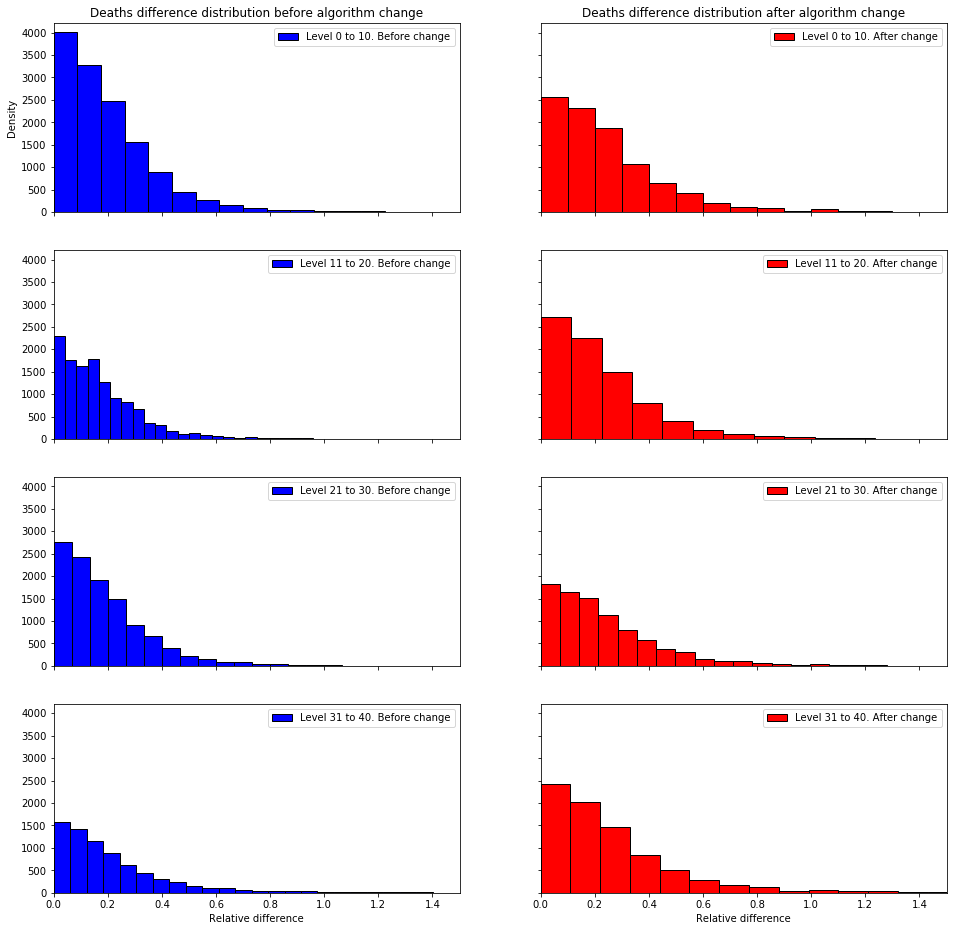

In [29]:
f, axes = plt.subplots(4, 2, sharex = True, sharey = True, figsize = (16, 16))
axes[0, 0].hist(df_before[df_before['t1_level'] <= 10]['deaths_diff'].dropna(), 
                bins = 80, color = 'blue', edgecolor = 'black')
axes[0, 1].hist(df_after[df_after['t1_level'] <= 10]['deaths_diff'].dropna(), 
                bins = 40, color = 'red', edgecolor = 'black')
axes[1, 0].hist(df_before[(df_before['t1_level'] > 10) & (df_before['t1_level'] <= 20)]['deaths_diff'].dropna(), 
         bins = 40, color = 'blue', edgecolor = 'black')
axes[1, 1].hist(df_after[(df_after['t1_level'] > 10) & (df_after['t1_level'] <= 20)]['deaths_diff'].dropna(), 
                bins = 40, color = 'red', edgecolor = 'black')
axes[2, 0].hist(df_before[(df_before['t1_level'] > 20) & (df_before['t1_level'] <= 30)]['deaths_diff'].dropna(), 
         bins = 40, color = 'blue', edgecolor = 'black')
axes[2, 1].hist(df_after[(df_after['t1_level'] > 20) & (df_after['t1_level'] <= 30)]['deaths_diff'].dropna(), 
                bins = 40, color = 'red', edgecolor = 'black')
axes[3, 0].hist(df_before[(df_before['t1_level'] > 30) & (df_before['t1_level'] <= 40)]['deaths_diff'].dropna(), 
         bins = 40, color = 'blue', edgecolor = 'black')
axes[3, 1].hist(df_after[(df_after['t1_level'] > 30) & (df_after['t1_level'] <= 40)]['deaths_diff'].dropna(), 
                bins = 40, color = 'red', edgecolor = 'black')
axes[0, 0].set_title('Deaths difference distribution before algorithm change')
axes[0, 1].set_title('Deaths difference distribution after algorithm change')
axes[0, 0].legend(['Level 0 to 10. Before change'])
axes[0, 1].legend(['Level 0 to 10. After change'])
axes[1, 0].legend(['Level 11 to 20. Before change'])
axes[1, 1].legend(['Level 11 to 20. After change'])
axes[2, 0].legend(['Level 21 to 30. Before change'])
axes[2, 1].legend(['Level 21 to 30. After change'])
axes[3, 0].legend(['Level 31 to 40. Before change'])
axes[3, 1].legend(['Level 31 to 40. After change'])
axes[3, 0].set_xlabel('Relative difference')
axes[3, 1].set_xlabel('Relative difference')
axes[0, 0].set_ylabel('Density')
plt.xlim([0, 1.5])
plt.show()

### Часть 3.3. Анализ позитивности или негативности изменений

Легко предположить, что игрок получает удовольствие от игры, когда делает фраг. Поэтому чем больше фрагов, тем больше игрок удовлетворен своей игрой (выносим за скобки случаи, когда фрагов слишком много и игрок от этого скучает). С другой стороны, чем больше смертей, тем меньше игрок удовлетворен игрой (выносим за скобки случаи, когда для игрока это особый челенж).

Исходя из этих идей попробуем оценить общую удовлетворенность игрока своим игровым опытом путем введения разницы между фрагами и смертями игрока. Чем больше будет это значение, тем больше игрок удовлетворен своей игрой.

Построим график распределения этой величины в зависимости от уровня игрока.

In [30]:
data_before['exp'] = data_before['frags'] - data_before['deaths']
data_after['exp'] = data_after['frags'] - data_after['deaths']

In [31]:
levels_before = np.sort(data_before['level'].unique())
exp_before = data_before.groupby(['level'])['exp'].mean().values
levels_after = np.sort(data_after['level'].unique())
exp_after = data_after.groupby(['level'])['exp'].mean().values

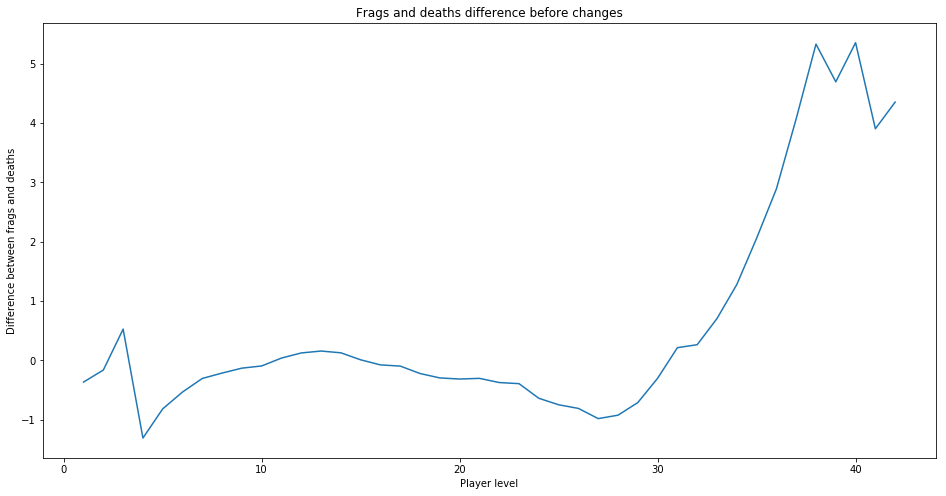

In [32]:
# Взглянем на график до внесения изменений

fig = plt.figure(figsize = (16, 8))
plt.plot(levels_before, exp_before)
plt.xlabel('Player level')
plt.ylabel('Difference between frags and deaths')
plt.title('Frags and deaths difference before changes')
plt.show()

Видим, что среднее число смертей превышает среднее число фрагов для игроков всех уровней.

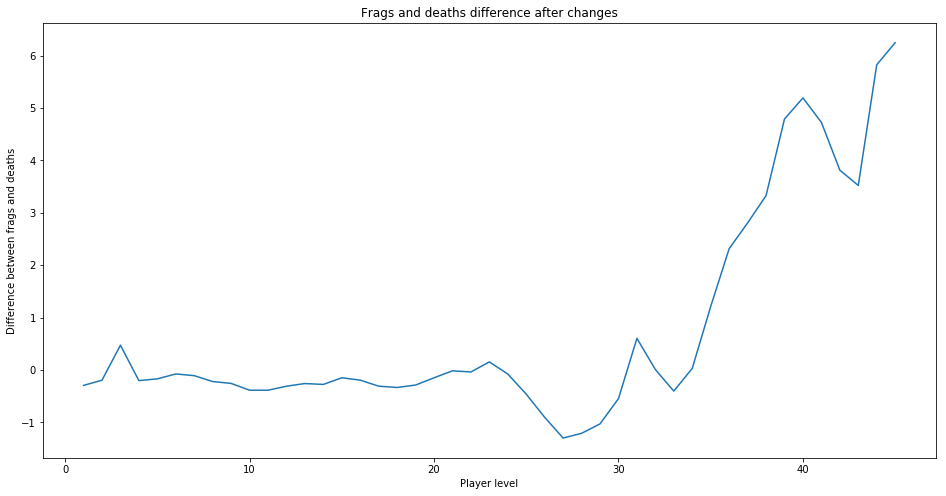

In [33]:
# А теперь график после внесения изменений

fig = plt.figure(figsize = (16, 8))
plt.plot(levels_after, exp_after)
plt.xlabel('Player level')
plt.ylabel('Difference between frags and deaths')
plt.title('Frags and deaths difference after changes')
plt.show()

Линия колеблется около нуля, при этом принимая в том числе и положительные значения, для новичков и средних игроков и резко повышается для опытных. 

Рассмотрим околонулевую часть крупнее.

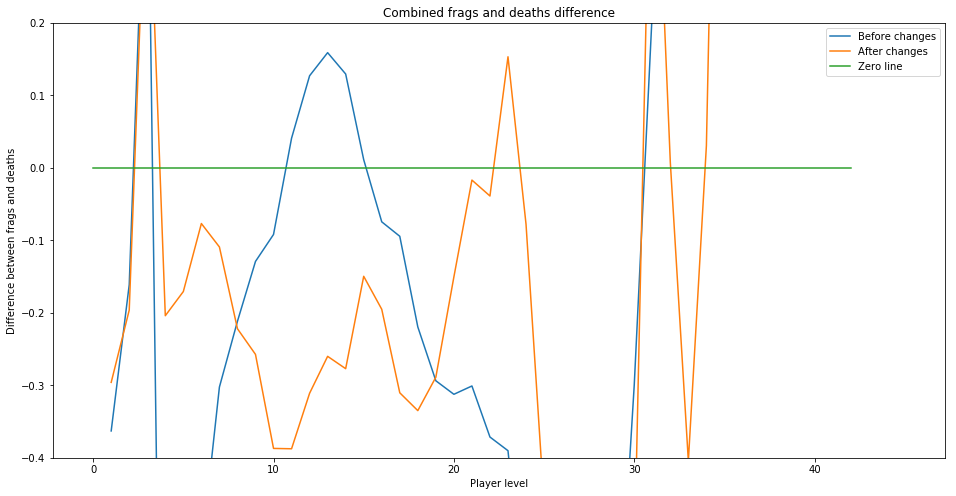

In [34]:
fig = plt.figure(figsize = (16, 8))
plt.plot(levels_before, exp_before, label = 'Before changes')
plt.plot(levels_after, exp_after, label = 'After changes')
x = np.linspace(0, 42, 2)
plt.plot(x, np.array([0 for i in xrange(len(x))]), label = 'Zero line')
plt.ylim([-0.4, 0.2])
plt.xlabel('Player level')
plt.ylabel('Difference between frags and deaths')
plt.title('Combined frags and deaths difference')
plt.legend()
plt.show()

До смены алгоритма игроки в среднем чаще умирали, чем убивали, причем, более или менее равномерно. После смены разброс стал гораздо больше. При этом наблюдается тенденция резкого роста разницы между фрагами и смертями для игроков высокого уровня (после 33-34). Но в целом данные по второй зависимости очень нестабильны.

Попробуем добавить стабильности, добавив к разнице фрагов и смертей количество ассистов. Посильное участие игрока в фраге тиммейта тоже может считаться положительным опытом.

In [35]:
data_before['exp_assist'] = data_before['frags'] - data_before['deaths'] + data_before['assists']
data_after['exp_assist'] = data_after['frags'] - data_after['deaths'] + data_after['assists']
exp_assist_before = data_before.groupby(['level'])['exp_assist'].mean().values
exp_assist_after = data_after.groupby(['level'])['exp_assist'].mean().values

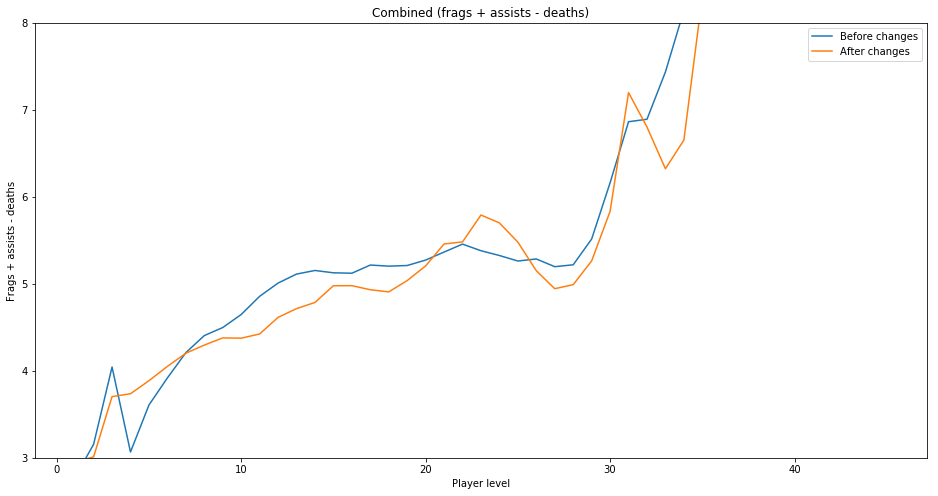

In [36]:
fig = plt.figure(figsize = (16, 8))
plt.plot(levels_before, exp_assist_before, label = 'Before changes')
plt.plot(levels_after, exp_assist_after, label = 'After changes')
x = np.linspace(0, 42, 2)
plt.ylim([3, 8])
plt.xlabel('Player level')
plt.ylabel('Frags + assists - deaths')
plt.title('Combined (frags + assists - deaths)')
plt.legend()
plt.show()

Теперь зависимость выглядит гораздо более интерпритируемо. Кривая до изменений по-прежнему относительно стабильна относительно уровня игроков. То есть, в целом эмоциональный окрас игрового опыта новичков и ветеранов были примерно сопоставимыми. После изменений явно заметен тренд на повышение "успешности" игроков с ростом уровня.
Так, игроки начальных уровней после смены алгоритма могли заметить некое усложнение игры, в то плане, что разница между положительным опытом (фраги и ассисты) и отрицательным (смерти) стала гораздо меньше. С примерно 15-го до 30-го уровней эффект от нововведений нивелируется, и разница в игровом опыте почти нет. А вот для игроков высокого уровня (от 30-го) удовольствие от игры все также заметно повышается.

Подытоживая, можно сказать, что новый алгоритм больше придется по душе опытным игрокам и почти не скажется на среднем сегменте. А вот новички почувствуют ухудшение своих ощущений от игры.

## Часть 4. Оценка общей эффективности нового алгоритма

Простым критерием хорошего матчмейкинга можно считать наслаждение игроков от игры. Добиться этого можно балансировкой команд таким образом, чтобы вероятности победы каждой из команд были примерно равны. На этапе анализа результатов оценить этот критерий можно по счету матча. Чем меньше средняя разность в финальном счете командого матча, тем более равной была игра.

In [37]:
team1_data_before = data[(data['team'] == 1) & (data['start_time'] < '2016-11-10')]
team1_data_after = data[(data['team'] == 1) & (data['start_time'] > '2016-11-10')]
team2_data_before = data[(data['team'] == 2) & (data['start_time'] < '2016-11-10')]
team2_data_after = data[(data['team'] == 2) & (data['start_time'] > '2016-11-10')]

team1_score_before = team1_data_before.groupby(['battle_id'])['frags'].mean().values
team1_score_after = team1_data_after.groupby(['battle_id'])['frags'].mean().values
team2_score_before = team2_data_before.groupby(['battle_id'])['frags'].mean().values
team2_score_after = team2_data_after.groupby(['battle_id'])['frags'].mean().values

score_before = np.abs(team1_score_before - team2_score_before)
score_after = np.abs(team1_score_after - team2_score_after)

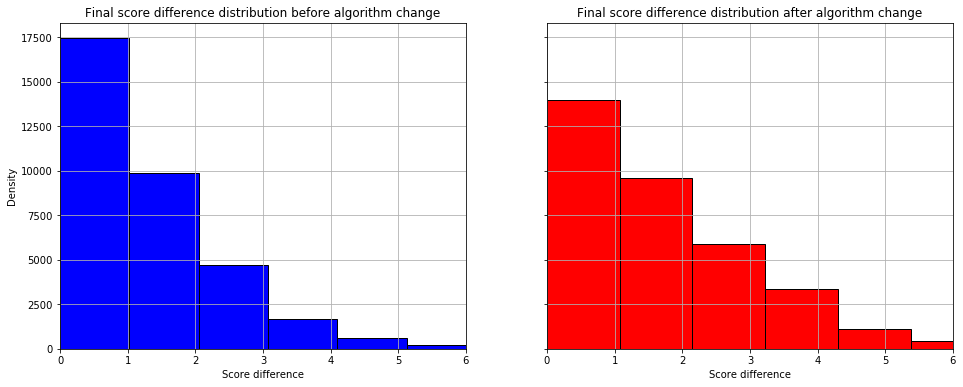

In [38]:
# Посмотрим на изменение разницы в счете матча до и после смены алгоритма

# Для наглядности результатов уравняем количество элементов в двух выборках
# Поскольку данные не упорядочены и их количество достаточно велико, мы можем взять len(score_after) первых значений
# большей выборки и считать эту подвыборку случайной

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey = True, figsize = (16, 6))
ax1.hist(score_before[:len(score_after)], bins = 10, color = 'blue', edgecolor = 'black')
ax1.set_title('Final score difference distribution before algorithm change')
ax2.hist(score_after, bins = 10, color = 'red', edgecolor = 'black')
plt.xlim([0, 6])
ax1.grid()
ax2.grid()
ax2.set_title('Final score difference distribution after algorithm change')
ax1.set_xlabel('Score difference')
ax2.set_xlabel('Score difference')
ax1.set_ylabel('Density')
ax1.set_ylabel('Density')
plt.show()

Видно, что график распределения разницы в счете после смены алгоритма имеет более тяжелый хвост, из чего следует, что средняя разница в счете после введения нового алгоритма больше. Исходя из моего начального предположения, это означает, что в среднем бои стали менее равными и упорными. Это приведет к тому, что каждый игрок чаще будет попадать в неравные бои, в которых у команды игрока будет заведомо меньше шансов на победу.

Учитывая все вышеперечисленное, в целом введение нового алгоритма подбора игроков приведет к ухудшению игрового опыта игроков, а значит, может быть охарактеризовано как негативное.